In [14]:
#@title Everything not mine is copyright 2020 Google LLC. Double-click here for full information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
 
# Yann LeCun and Corinna Cortes hold the copyright of MNIST dataset,
# which is a derivative work from original NIST datasets. 
# MNIST dataset is made available under the terms of the 
# Creative Commons Attribution-Share Alike 3.0 license.

This Notebook is heavily modified from the MLCC programming project with single-digit images here:
https://colab.research.google.com/github/google/eng-edu/blob/master/ml/cc/exercises/multi-class_classification_with_MNIST.ipynb

In [15]:
# load some standard utilities.
%tensorflow_version 2.x
#from __future__ import absolute_import, division, print_function, unicode_literals
 
import random as rd
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
 
# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.3f}".format
 
# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)
 
print("Loaded modules.")

Loaded modules.


In [16]:
tf.__version__

'2.3.0'

In [17]:
# load the dataset.
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
#print("Loaded the train and test sets.")

In [44]:
kaggle = pd.read_csv('/content/test.csv')

In [18]:
kaggle_norm = np.asarray(kaggle/255.)
x_train_norm = x_train/255.
x_test_norm = x_test/255.

## Create a deep neural net model and a convolutional neural network to compare

In [49]:
kaggle_norm = kaggle_norm.reshape(28000, 28, 28)
x_train_norm = x_train_norm.reshape(60000, 28, 28)
x_test_norm = x_test_norm.reshape(10000, 28, 28)

In [50]:
# SET UP A DEEP NEURAL NET 
 
def create_DNN(learning_rate):
    """Create and compile a deep neural net."""  
    # Define the kind of model to use.
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.1)) #avoid overfitting to train set
    model.add(tf.keras.layers.Dense(units=256, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=100, activation='softmax'))     
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy']) 
    return model 

In [20]:
 # SET UP A **CONVOLUTIONAL** NEURAL NET 
 
def create_CNN(learning_rate):
    """Create and compile a convolutional neural net."""  
    # Define the kind of model to use.
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, 6, activation='relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.Conv2D(64, 4, activation='relu'))
    model.add(tf.keras.layers.Conv2D(128, 2, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=100, activation='softmax'))     
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy']) 
    return model

In [22]:
 # train on the training set with 10% held back for validation #
def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):

    history = model.fit(x=train_features, y=train_label, 
                        batch_size=batch_size,
                        epochs=epochs, shuffle=True, 
                        validation_split=validation_split)

    # Gather the model's metrics after each round of training
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist

In [ ]:
# The adjustable "hyperparameters" for the model
learning_rate = 0.001
epochs = 20
batch_size = 500
validation_split = 0.1
 
dense_NN = create_DNN(learning_rate)
 
# TRAIN:
epochs_DNN, hist_DNN = train_model(dense_NN, x_train_norm, y_train, 
                                    epochs, batch_size, validation_split)
 
# EVALUATE AGAINST THE TEST SET:
print("\n Evaluate the new model against the test set:")
dense_NN.evaluate(x=x_test_norm, 
                  y=y_test, 
                  batch_size=batch_size)

In [51]:
kaggle_norm = kaggle_norm.reshape(28000, 28, 28, 1)
x_train_norm = x_train_norm.reshape(60000, 28, 28, 1)
x_test_norm = x_test_norm.reshape(10000, 28, 28, 1)

In [ ]:
# Train and evalate CNN
 
convolute_NN = create_CNN(learning_rate)
 
# TRAIN:
epochs_CNN, hist_CNN = train_model(convolute_NN, x_train_norm, y_train, epochs, batch_size, validation_split)
 
# EVALUATE AGAINST THE TEST SET:
print("\n Evaluate the new model against the test set:")
convolute_NN.evaluate(x=x_test_norm, 
                        y=y_test, 
                        batch_size=batch_size)

In [68]:
dense_NN.evaluate(x=x_test_norm,y=y_test, batch_size=batch_size)

20/20 [==============================] - 0s 2ms/step - loss: 0.0705 - accuracy: 0.9807


[0.070480115711689, 0.9807000160217285]

In [69]:
convolute_NN.evaluate(x=x_test_norm,y=y_test, batch_size=batch_size)

20/20 [==============================] - 0s 4ms/step - loss: 0.0483 - accuracy: 0.9879


[0.04827136918902397, 0.9879000186920166]

In [ ]:
def getKaggles(how_many=10):  
    guesses = pd.DataFrame(columns=['Guess','P(G)'])  
    #answers['Answer'] = y_test[:how_many]
    predicts = convolute_NN.predict(kaggle_norm).round(5)
    for j in range(0,how_many): # how_many is the number of examples to guess
        probs = predicts[j] # one row of 100 probabilities 
        maxr = max(probs)   # top probability
        for i in range(0,100):
            if probs[i] == maxr:
                guesses.at[j,'Guess'] = i
                guesses.at[j,'P(G)'] = maxr*100
    return guesses
print("Loaded function getKaggles.")
print("Getting answers..." )

# LOAD UP ALL THE GUESSES (W/ PROBABILITES) FOR 
# EACH EXAMPLE IMAGE IN THE NORMALIZED TEST SET
guesses = getKaggles(len(kaggle_norm))
guesses

In [63]:
guesses["Guess"].to_csv('guesses.csv',header=False,index=None) #

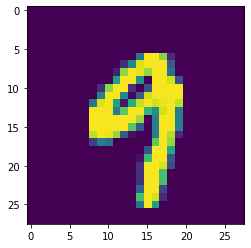

In [82]:
dig = kaggle.iloc[27998]
dig = np.reshape(list(dig),(28,28))
plt.imshow(dig)

##Visualizations

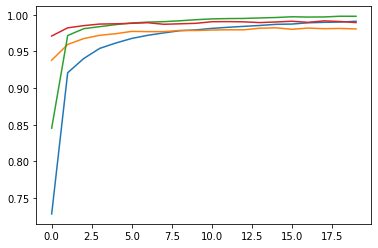

In [52]:
# Plot a graph of the 'accuracy' metric vs. epochs:
plt.plot(range(epochs),hist_DNN["accuracy"])
plt.plot(range(epochs),hist_DNN["val_accuracy"])
plt.plot(range(epochs),hist_CNN["accuracy"])
plt.plot(range(epochs),hist_CNN["val_accuracy"])